# 线性回归简洁实现
深度学习框架可以自动化基于梯度的学习算法中重复性的工作，上一节中，我们仅仅通过张量来进行数据存储和线性代数运输，运用了自动微分来计算梯度，实际上，由于数据迭代器、损失函数、优化器、神经网络层很常用，现代深度学习框架已经为我们实现了这些组件。
在本节中，我们将介绍如何通过深度学习框架来简洁地实现线性回归模型。

## 生成数据集
我们使用上一节中相同的方法来生成线性回归需要拟合的数据：

In [3]:
import torch
import warnings 
warnings.filterwarnings('ignore')
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 0.01, size=(num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

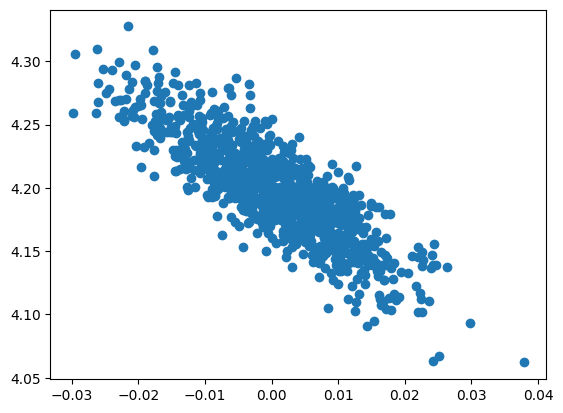

In [5]:
import matplotlib.pyplot as plt
plt.scatter(features[:, 1], labels[:])

我们也可以直接调用d2l中封装好的synthetic_data（）函数来生成数据，避免重复代码：

In [6]:
from d2l import torch as d2l
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

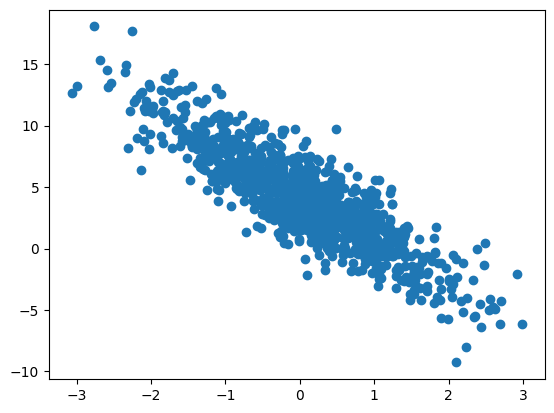

In [8]:
plt.scatter(features[:, 1], labels[:])

## 读取数据集
我们可以[**调用框架中现有的API来读取数据**]。
我们将`features`和`labels`作为API的参数传递，并通过数据迭代器指定`batch_size`。
此外，布尔值`is_train`表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

In [13]:
import torch
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [14]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [17]:
next(iter(data_iter))

[tensor([[ 0.8785, -0.3578],
         [ 0.6546,  0.9490],
         [ 0.1898,  0.0656],
         [-0.4084,  1.4085],
         [-0.0019, -1.0538],
         [-0.4078, -0.4337],
         [-1.1592,  0.5781],
         [ 0.4396,  1.7029],
         [-1.5005,  1.2980],
         [ 0.7625,  1.4023]]),
 tensor([[ 7.1601],
         [ 2.2900],
         [ 4.3483],
         [-1.4096],
         [ 7.7641],
         [ 4.8669],
         [-0.0907],
         [-0.7064],
         [-3.1940],
         [ 0.9603]])]

## 定义模型
对于标准深度学习模型，我们可以使用框架的预定义的层，这样我们就只需关注使用哪些层来构造模型，而不必关注层的实现细节。我们首先定义一个模型变量，它是一个Sequential类的实例。Sequential类将多个层串联在一起。当给定输入数据时，Sequential实例将数据传入到第一层，然后依次类推。

线性回归是一个单层线性网络架构，也被称为全连接层，因为它的每一个输入都通过矩阵-向量乘法得到它的每个输出。

在Pytorch中，全连接层在Linear类中定义。值得注意的是，我们将两个参数传递到nn.Linear中：第一个指定输入的特征形状，即2,第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [18]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

## 初始化模型参数
在使用`net`之前，我们需要初始化模型参数。
如在线性回归模型中的权重和偏置。
深度学习框架通常有预定义的方法来初始化参数。
在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样，
偏置参数将初始化为零

正如我们在构造`nn.Linear`时指定输入和输出尺寸一样，
现在我们能直接访问参数以设定它们的初始值。
我们通过`net[0]`选择网络中的第一个图层，
然后使用`weight.data`和`bias.data`方法访问参数。
我们还可以使用替换方法`normal_`和`fill_`来重写参数值。

In [19]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 定义损失函数
[**计算均方误差使用的是`MSELoss`类，也称为平方$L_2$范数**]。
默认情况下，它返回所有样本损失的平均值。

In [21]:
loss = nn.MSELoss()

## 定义优化算法
小批量随机梯度下降算法是一种优化神经网络的标准工具，
PyTorch在`optim`模块中实现了该算法的许多变种。
当我们(**实例化一个`SGD`实例**)时，我们要指定优化的参数
（可通过`net.parameters()`从我们的模型中获得）以及优化算法所需的超参数字典。
小批量随机梯度下降只需要设置`lr`值，这里设置为0.03。

In [20]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练
通过深度学习框架的高级API来实现我们的模型只需要相对较少的代码。
我们不必单独分配参数、不必定义我们的损失函数，也不必手动实现小批量随机梯度下降。
当我们需要更复杂的模型时，高级API的优势将大大增加。
当我们有了所有的基本组件，[**训练过程代码与我们从零开始实现时所做的非常相似**]。

回顾一下：在每个迭代周期里，我们将完整遍历一次数据集（`train_data`），
不停地从中获取一个小批量的输入和相应的标签。
对于每一个小批量，我们会进行以下步骤:
* 通过调用net（X）生成预测值并计算损失
* 通过进行反向传播来计算梯度
* 通过调用优化器来更新模型参数

为了更好地衡量训练效果，我们计算每个迭代周期后的损失：

In [23]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)  # 前向传播及计算损失
        trainer.zero_grad()  # 梯度清零
        l.backward()  # 反向传播
        trainer.step()  # 更新参数
    l = loss(net(features), labels)  # 一个epoch之后，用所有数据样本计算误差
    print(f'epoch: {epoch + 1}, loss {l:f}')

epoch: 1, loss 0.000256
epoch: 2, loss 0.000095
epoch: 3, loss 0.000095


下面我们[**比较生成数据集的真实参数和通过有限数据训练获得的模型参数**]。
要访问参数，我们首先从`net`访问所需的层，然后读取该层的权重和偏置。
正如在从零开始实现中一样，我们估计得到的参数与生成数据的真实参数非常接近。

In [24]:
w = net[0].weight.data
b = net[0].bias.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0002,  0.0002])
b的估计误差： tensor([-0.0002])


In [25]:
w

tensor([[ 2.0002, -3.4002]])

In [26]:
b

tensor([4.2002])

In [27]:
true_w, true_b

(tensor([ 2.0000, -3.4000]), 4.2)

## 小结
* 构建原始数据集data，调用torch.utils.data模块里的DataLoader类，传入原始数据集data、batch_size,以及是否shuffle构造一个数据集迭代对象data_iter
* 定义模型：可以使用nn.Sequential类将多个层串联在一起，构造模型net
* 定义损失函数loss，直接使用nn.MSELoss
* 定义优化器，使用torch.optim.SGD,需要传入模型的参数net.parameters()以及学习率lr
* 初始化参数：通过_结尾的方法将参数替换，从而初始化参数
* 训练模型，指定训练的epochs，然后对每一个epoch循环:
    * 从数据集迭代器中加载特征矩阵和标签
    * 前向传播预测net(X)并计算损失l=loss(net(X), y)
    * 梯度清零
    * 反向传播
    * 更新参数